Earlier My score was 
image.png

Below score using LightLbm Model

Now it is 
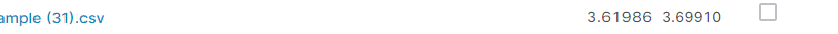

#https://www.youtube.com/watch?v=DfZpljN9BYU&t=2042s  
Helped me to understand datasets.

Based on this I did required changes on my model.

**Outlier handle**

As is evident from multiple discussions:¶
https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73571
https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73922
https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73024
The 2207 rows with target values < -33 do seem to have an important role in this synthesized dataset.

So its very important for us to handle outlier carefully.
Even i have seen when i handled outlier my kaggle score improved alot

**Added new features holiday features**

This heavily borrowed from Chau Ngoc Huynh's https://www.kaggle.com/chauhuynh/my-first-kernel-3-699. I try to create some features using workalendar, which was suggested on Bojan Tunguz's post (https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/74052) by Kjetil Åmdal-Sævik.¶

 I have  created new features in the train and test sets based on the number of working days (in the Brazilian calendar) between the first_active_month and the 8 major national holidays.This holiday features improved alot my score

Additional features which i borrowed from 
https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/82107
https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/82055

elapsed_time ,total purshase amount and so many features idea i borrowed from above discussion

**Combine model both with outlier and without outlier**.


Got idea from below

The basic idea behind this is:

Training model without outliers make the model more accurate for non-outliers.
A great proportion of the error is caused by outliers, so we need to use a model training with outliers to predict them. How to find them out? build a classifier!

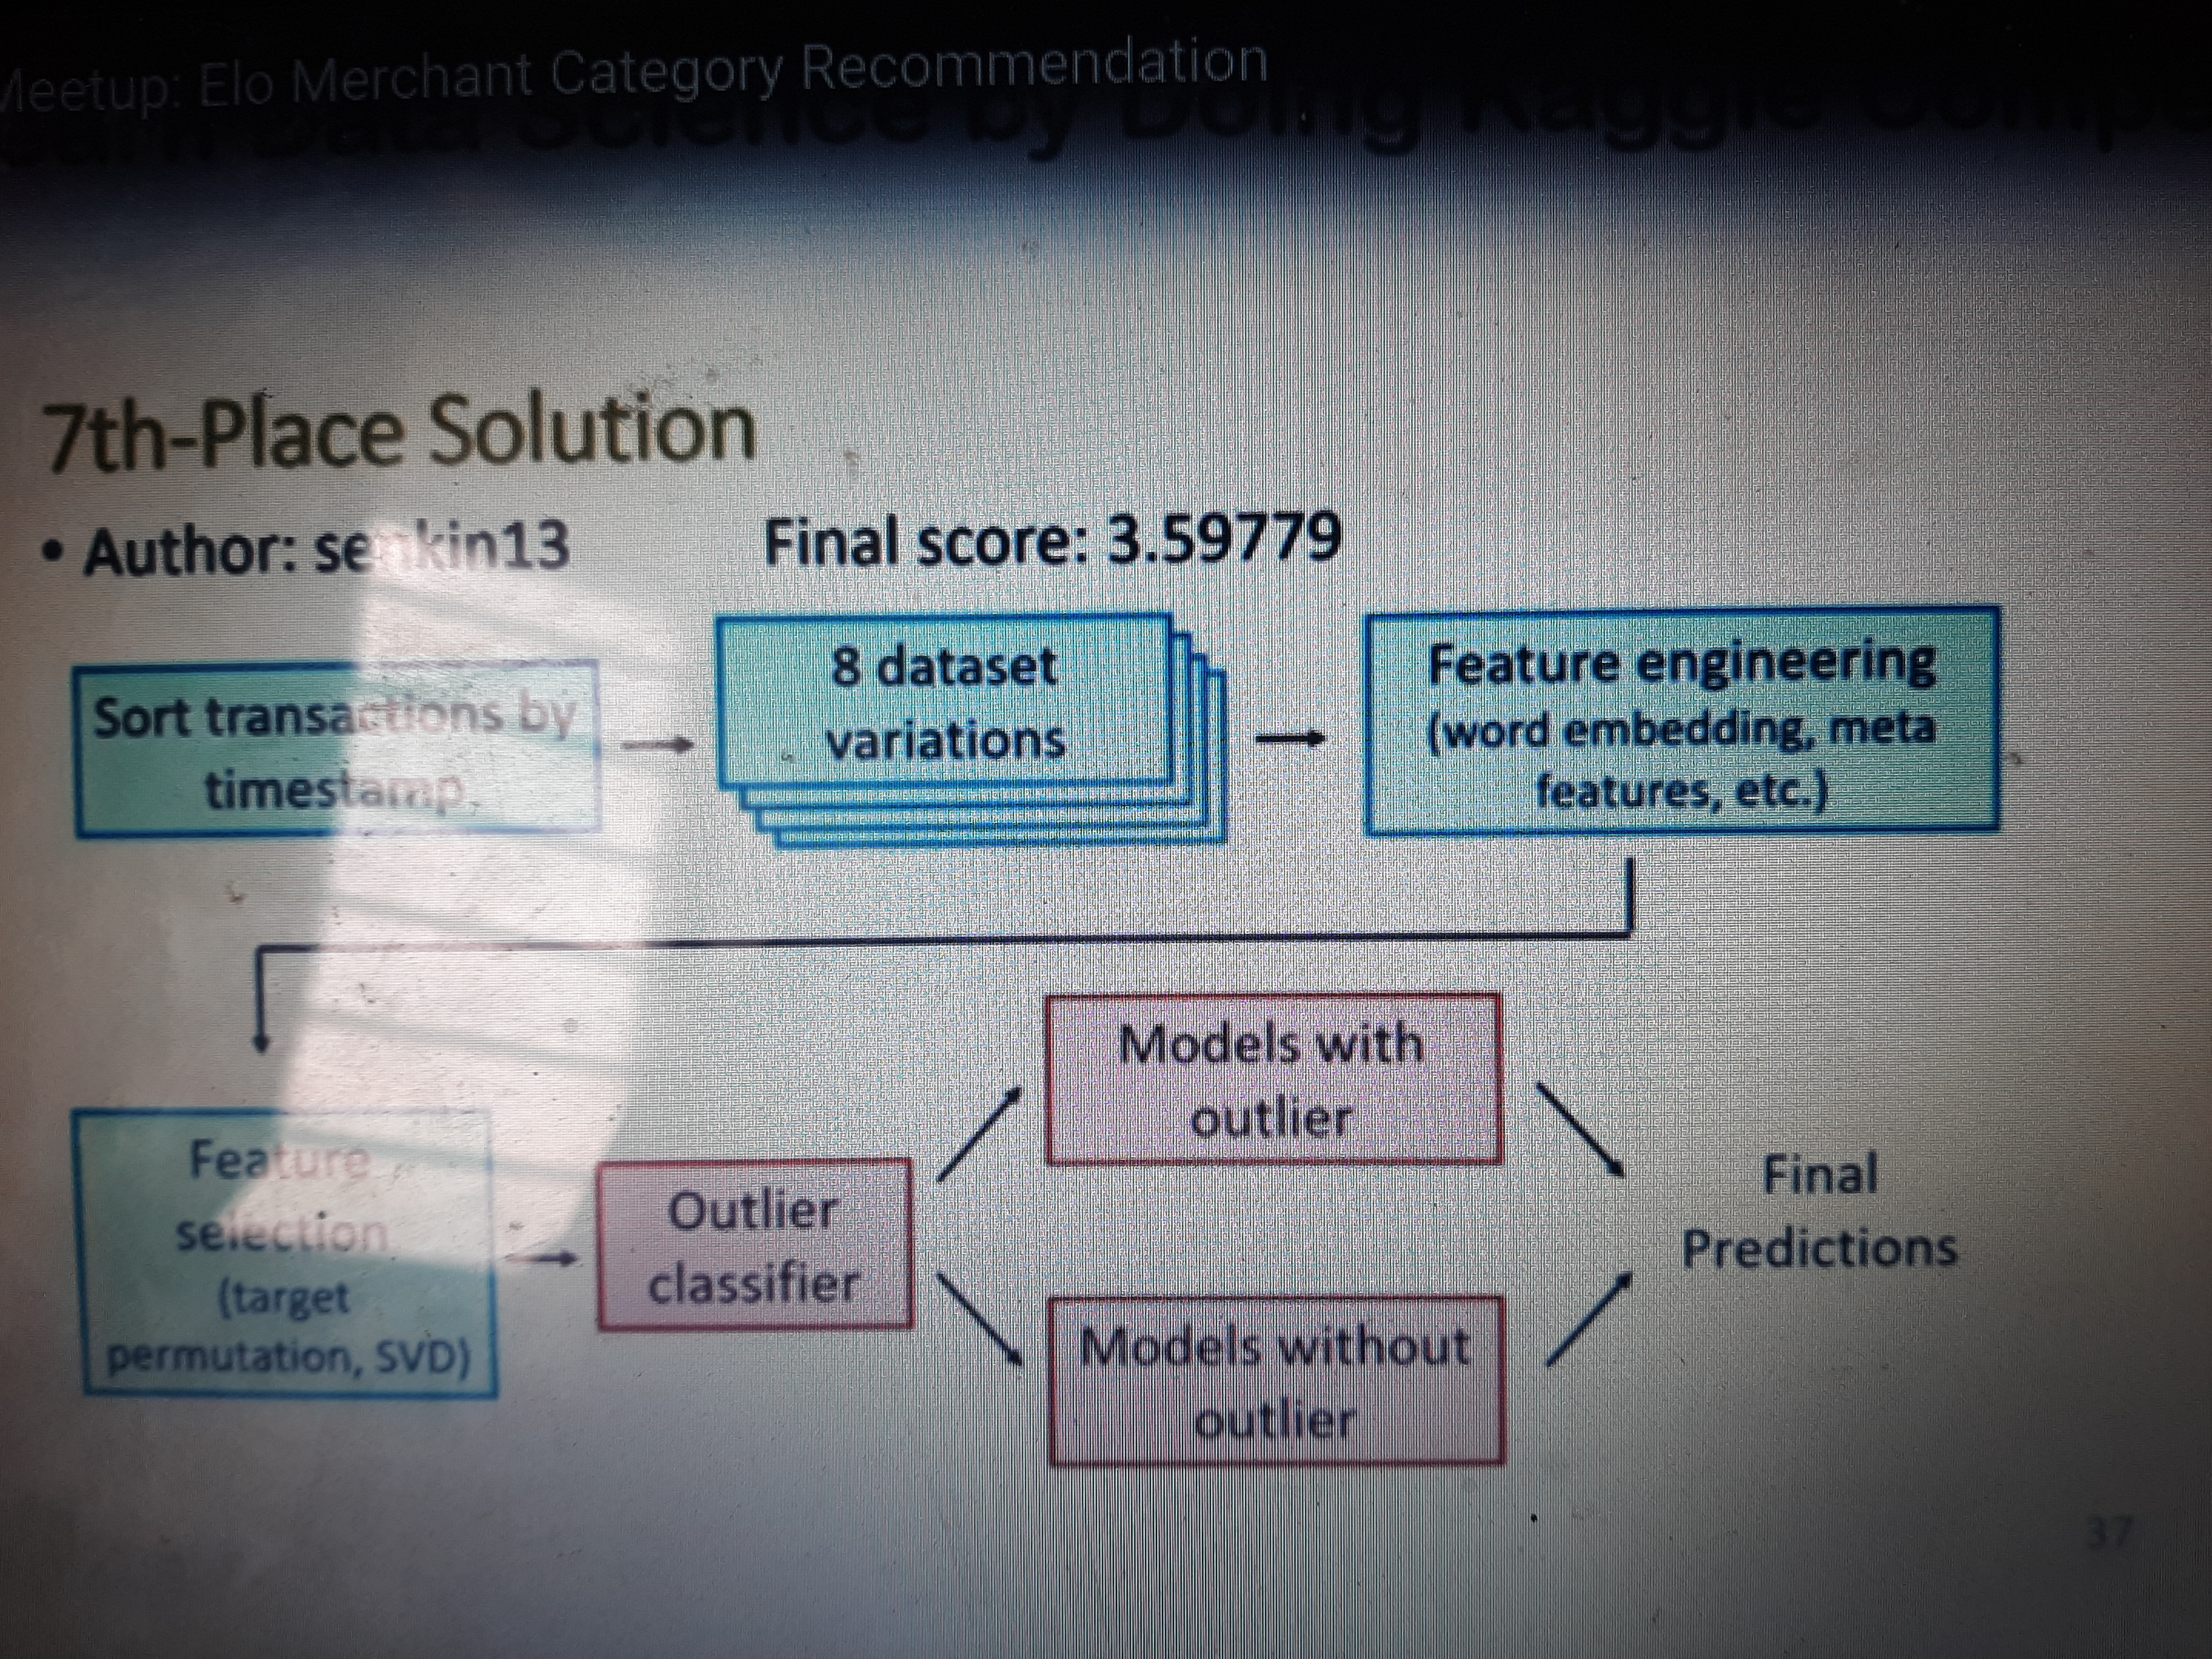

In [ ]:
Image(filename='/content/drive/MyDrive/elo-merchant-category-recommendation/20210302_140807.jpg')

**LightLbm Model**

I played with Xgboost,catboost,esmblemed model. I hypertuned it tried to managed it with my low configure system. Even these models did not provide better result ,compare to lightlbm.

**Observation **

Faster training speed and higher efficiency.

Lower memory usage.

Better accuracy.

Support of parallel and GPU learning.

Capable of handling large-scale data.



In [ ]:
# Import all dependencies
import pandas as pd
import numpy as np
from sklearn import preprocessing
import warnings
import datetime
import datetime
from datetime import date, datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)
#https://www.kaggle.com/raddar/card-id-loyalty-different-points-in-time

from workalendar.america import Brazil
from IPython.display import Image
import pickle


In [ ]:
!pip3 install workalendar

In [ ]:
import os
import gc

warnings.filterwarnings("ignore")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Reduce the memory usage - Inspired by Panchajanya Banerjee
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [ ]:
new_trans = pd.read_csv('/content/drive/MyDrive/elo-merchant-category-recommendation/new_merchant_transactions.csv')


In [ ]:
new_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963031 entries, 0 to 1963030
Data columns (total 14 columns):
 #   Column                Dtype  
---  ------                -----  
 0   authorized_flag       object 
 1   card_id               object 
 2   city_id               int64  
 3   category_1            object 
 4   installments          int64  
 5   category_3            object 
 6   merchant_category_id  int64  
 7   merchant_id           object 
 8   month_lag             int64  
 9   purchase_amount       float64
 10  purchase_date         object 
 11  category_2            float64
 12  state_id              int64  
 13  subsector_id          int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 209.7+ MB


In [ ]:
hist_trans = pd.read_csv('/content/drive/MyDrive/elo-merchant-category-recommendation/historical_transactions.csv')


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/elo-merchant-category-recommendation/train.csv")


In [ ]:
test = pd.read_csv("/content/drive/MyDrive/elo-merchant-category-recommendation/test.csv")

In [ ]:
train=reduce_mem_usage(train)

Mem. usage decreased to  4.04 Mb (56.2% reduction)


In [ ]:
test==reduce_mem_usage(test)

Mem. usage decreased to  2.24 Mb (52.5% reduction)


first_active_month  card_id  feature_1  feature_2  feature_3
0                     True     True       True       True       True
1                     True     True       True       True       True
2                     True     True       True       True       True
3                     True     True       True       True       True
4                     True     True       True       True       True
...                    ...      ...        ...        ...        ...
123618                True     True       True       True       True
123619                True     True       True       True       True
123620                True     True       True       True       True
123621                True     True       True       True       True
123622                True     True       True       True       True

[123623 rows x 5 columns]

In [ ]:
hist_trans=reduce_mem_usage(hist_trans)

Mem. usage decreased to 1749.11 Mb (43.7% reduction)


In [ ]:
new_trans=reduce_mem_usage(new_trans)

Mem. usage decreased to 114.20 Mb (45.5% reduction)


In [ ]:
def missingvalue(df):
    for i in df.columns:
        if df[i].dtype == "object":
            df[i] = df[i].fillna("other")
        elif (df[i].dtype == "int64" or df[i].dtype == "float64"):
            df[i] = df[i].fillna(df[i].mean())
        else:
            pass
    return df

# missing values for all datasets
for df in [train, test,new_trans,  hist_trans]:
    missingvalue(df)    

In [ ]:
train=train.drop_duplicates(subset=['target']) 

In [ ]:
for df in [hist_trans,new_trans]:
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

In [ ]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [ ]:
#https://stackoverflow.com/questions/33817380/workalendar-europe-library-how-to-find-holidays
cal = Brazil()
for yr in [2011,2012,2013,2014,2015,2016,2017]:
    print(yr,cal.holidays(yr))

2011 [(datetime.date(2011, 1, 1), 'New year'), (datetime.date(2011, 4, 21), "Tiradentes' Day"), (datetime.date(2011, 4, 24), 'Easter Sunday'), (datetime.date(2011, 5, 1), 'Labour Day'), (datetime.date(2011, 9, 7), 'Independence Day'), (datetime.date(2011, 10, 12), 'Our Lady of Aparecida'), (datetime.date(2011, 11, 2), "All Souls' Day"), (datetime.date(2011, 11, 15), 'Republic Day'), (datetime.date(2011, 12, 25), 'Christmas Day')]
2012 [(datetime.date(2012, 1, 1), 'New year'), (datetime.date(2012, 4, 8), 'Easter Sunday'), (datetime.date(2012, 4, 21), "Tiradentes' Day"), (datetime.date(2012, 5, 1), 'Labour Day'), (datetime.date(2012, 9, 7), 'Independence Day'), (datetime.date(2012, 10, 12), 'Our Lady of Aparecida'), (datetime.date(2012, 11, 2), "All Souls' Day"), (datetime.date(2012, 11, 15), 'Republic Day'), (datetime.date(2012, 12, 25), 'Christmas Day')]
2013 [(datetime.date(2013, 1, 1), 'New year'), (datetime.date(2013, 3, 31), 'Easter Sunday'), (datetime.date(2013, 4, 21), "Tiradente

In [ ]:
cal.holidays(2013)[1]

(datetime.date(2013, 3, 31), 'Easter Sunday')

In [ ]:
for df in [hist_trans,new_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
   
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']

In [ ]:
aggs = {}
for col in ['purchase_amount','month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    hist_trans[col+'_mean'] =hist_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']    

new_columns = get_new_columns('hist',aggs)
hist_trans_group = hist_trans.groupby('card_id').agg(aggs)
hist_trans_group.columns = new_columns
hist_trans_group.reset_index(drop=False,inplace=True)
hist_trans_group['hist_purchase_amount_diff'] =hist_trans_group['hist_purchase_amount_max']-hist_trans_group['hist_purchase_amount_mean']
hist_trans_group['hist_purchase_date_diff'] = (hist_trans_group['hist_purchase_date_max'] - hist_trans_group['hist_purchase_date_min']).dt.days
hist_trans_group['hist_purchase_date_average'] = hist_trans_group['hist_purchase_date_diff']/hist_trans_group['hist_card_id_size']
hist_trans_group['hist_purchase_date_uptonow'] = (datetime.datetime.today() - hist_trans_group['hist_purchase_date_max']).dt.days
train = train.merge(hist_trans_group,on='card_id',how='left')
test = test.merge(hist_trans_group,on='card_id',how='left')
del hist_trans_group;gc.collect()


63

In [ ]:
train['hist_purchase_amount_sum']

0       -165.968735
1       -210.006332
2        -29.167391
3        -49.491364
4        -48.687656
            ...    
19430    -50.019966
19431   -431.735321
19432    -10.638801
19433      0.348991
19434    -90.075104
Name: hist_purchase_amount_sum, Length: 19435, dtype: float32

In [ ]:
#https://stackoverflow.com/questions/33817380/workalendar-europe-library-how-to-find-holidays
aggs = {}
for col in ['purchase_amount','month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    new_trans[col+'_mean'] = new_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']
    
new_columns = get_new_columns('new_hist',aggs)
hist_trans_group = new_trans.groupby('card_id').agg(aggs)

hist_trans_group.columns = new_columns
hist_trans_group.reset_index(drop=False,inplace=True)
hist_trans_group['new_hist_purchase_amount_diff']=hist_trans_group['new_hist_purchase_amount_max'] -hist_trans_group['new_hist_purchase_amount_mean']
hist_trans_group['new_hist_purchase_date_diff'] = (hist_trans_group['new_hist_purchase_date_max'] - hist_trans_group['new_hist_purchase_date_min']).dt.days
hist_trans_group['new_hist_purchase_date_average'] = hist_trans_group['new_hist_purchase_date_diff']/hist_trans_group['new_hist_card_id_size']
hist_trans_group['new_hist_purchase_date_uptonow'] = (datetime.datetime.today() - hist_trans_group['new_hist_purchase_date_max']).dt.days
train = train.merge(hist_trans_group,on='card_id',how='left')
test = test.merge(hist_trans_group,on='card_id',how='left')
del hist_trans_group;gc.collect()


22

In [ ]:
train['new_hist_purchase_amount_sum']

0       -13.242188
1        -4.355469
2        -0.700195
3        -4.656250
4       -19.921875
           ...    
19430    -2.214844
19431    -4.640625
19432    -0.566406
19433    -0.527832
19434     0.301270
Name: new_hist_purchase_amount_sum, Length: 19435, dtype: float16

In [ ]:
del hist_trans;gc.collect()
del new_trans;gc.collect()


0

In [ ]:
train.shape

(201917, 80)

In [ ]:
train['outliers'] = 0
train.loc[train['target'] < -30, 'outliers'] = 1
train['outliers'].value_counts()

0    19434
1        1
Name: outliers, dtype: int64

In [ ]:
for df in [train,test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'], errors='coerce')
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    df['hist_first_buy'] = (pd.to_datetime(df['hist_purchase_date_min'])- df['first_active_month']).dt.days
    
    #df['new_hist_first_buy'] = pd.to_datetime(df['new_hist_purchase_date_min'], errors='coerce') - df['first_active_month']
                                
    for f in ['hist_purchase_date_max','hist_purchase_date_min',]:
     
      df[f] = df[f].astype(np.int64) * 1e-9
    #df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']
     
    

for f in ['feature_1','feature_2','feature_3']:
    order_label = train.groupby([f])['outliers'].mean()
    train[f] = train[f].map(order_label)
    test[f] = test[f].map(order_label)

some features for the national holidays

In [ ]:
# Dealing with the one nan intest.first_active_month a bit arbitrarily for now
test.loc[test['first_active_month'].isna(),'first_active_month'] =test.iloc[11577]['first_active_month']

In [ ]:
train['first_active_month'].dropna
test['first_active_month'].dropna

def nationalholiday(df):

  
  df['date'] =df['first_active_month'].dt.date 
  

  #df = df.dropna(subset=['date'])
  #df['date'] = df['date'].astype(int)
  #df['date'] = df['date'].dt.date

    #df['date']=df['date'].isnull()
  df['day_diff1'] = df['date'].apply(lambda x: cal.get_working_days_delta(x,cal.holidays(int(x.year))[0][0]))
  
  df['day_diff2'] = df['date'].apply(lambda x: cal.get_working_days_delta(x,cal.holidays(int(x.year))[1][0]))
  df['day_diff3'] = df['date'].apply(lambda x: cal.get_working_days_delta(x,cal.holidays(int(x.year))[2][0]))
  df['day_diff4'] = df['date'].apply(lambda x: cal.get_working_days_delta(x,cal.holidays(int(x.year))[3][0]))
  df['day_diff5'] = df['date'].apply(lambda x: cal.get_working_days_delta(x,cal.holidays(int(x.year))[4][0]))
  df['day_diff6'] = df['date'].apply(lambda x: cal.get_working_days_delta(x,cal.holidays(int(x.year))[5][0]))
  df['day_diff7'] = df['date'].apply(lambda x: cal.get_working_days_delta(x,cal.holidays(int(x.year))[6][0]))
  df['day_diff8'] = df['date'].apply(lambda x: cal.get_working_days_delta(x,cal.holidays(int(x.year))[7][0]))
  df.drop(['date'],axis=1,inplace=True)
  return df
for df in [train, test]:
    nationalholiday(df)     

In [ ]:
train['day_diff1']

0        107
1          0
2        150
3        173
4        214
        ... 
19430    214
19431      0
19432    214
19433    128
19434    150
Name: day_diff1, Length: 19435, dtype: int64

In [ ]:
gc.collect()

145

In [ ]:
target = train['target']
del train['target']

In [ ]:
train.shape

(19435, 94)

In [ ]:
train['outliers'].describe()

count    19435.000000
mean         0.000051
std          0.007173
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: outliers, dtype: float64

In [ ]:
train=reduce_mem_usage(train)

Mem. usage decreased to  4.11 Mb (65.5% reduction)


In [ ]:
test=reduce_mem_usage(test)

Mem. usage decreased to 26.64 Mb (64.5% reduction)


In [ ]:
for col in train_columns:
    for df in [train, test]:
        if df[col].dtype == "float64" :
            df[col] = df[col].fillna(df[col].mean())

model without outlier

In [ ]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train,train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    pickle.dump(clf, open('model.pkl','wb'))
    
    predictions += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    pickle.dump(test[train_columns],open('test.pkl','wb'))
np.sqrt(mean_squared_error(oof, target))


fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 2.13468	valid_1's rmse: 2.21818
[200]	training's rmse: 2.02453	valid_1's rmse: 2.16877
[300]	training's rmse: 1.95736	valid_1's rmse: 2.15481
[400]	training's rmse: 1.90597	valid_1's rmse: 2.15014
[500]	training's rmse: 1.86185	valid_1's rmse: 2.14786
[600]	training's rmse: 1.82278	valid_1's rmse: 2.14722
[700]	training's rmse: 1.78732	valid_1's rmse: 2.14661
[800]	training's rmse: 1.75391	valid_1's rmse: 2.14626
Early stopping, best iteration is:
[789]	training's rmse: 1.75752	valid_1's rmse: 2.14594
fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 2.15443	valid_1's rmse: 2.14329
[200]	training's rmse: 2.04549	valid_1's rmse: 2.0876
[300]	training's rmse: 1.97872	valid_1's rmse: 2.06643
[400]	training's rmse: 1.9263	valid_1's rmse: 2.05705
[500]	training's rmse: 1.88177	valid_1's rmse: 2.05193
[600]	training's rmse: 1.8433	valid_1's rmse: 2.04885
[70

2.124550504142991

In [ ]:
sample=pd.read_csv('/content/drive/MyDrive/elo-merchant-category-recommendation/sample .csv')

In [ ]:
test2 = pd.read_csv('/content/drive/MyDrive/elo-merchant-category-recommendation/test.csv')

sub_df = pd.DataFrame({"card_id":test2["card_id"].values})
sub_df["target"] = predictions
output=sub_df.to_csv("/content/drive/MyDrive/elo-merchant-category-recommendation/sample.csv", index=False, header =1)

In [ ]:
pickle.dump(output, open('output.pkl','wb'))

In [ ]:
model_without_outliers = pd.DataFrame({"card_id":test["card_id"].values})
model_without_outliers["target"] = predictions

Model with outlier

In [ ]:
import lightgbm as lgb


In [ ]:
target = train['outliers']# target as outlier
del train['outliers']
del train['target']

In [ ]:
target

In [ ]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train,target.values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))


fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.0984315	valid_1's rmse: 0.101132
[200]	training's rmse: 0.0959424	valid_1's rmse: 0.10058
[300]	training's rmse: 0.0942604	valid_1's rmse: 0.10043
[400]	training's rmse: 0.0931251	valid_1's rmse: 0.10042
[500]	training's rmse: 0.0923068	valid_1's rmse: 0.100391
[600]	training's rmse: 0.0916622	valid_1's rmse: 0.100365
[700]	training's rmse: 0.0910175	valid_1's rmse: 0.10035
[800]	training's rmse: 0.0904555	valid_1's rmse: 0.100335
Early stopping, best iteration is:
[797]	training's rmse: 0.0904688	valid_1's rmse: 0.100334
fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.0985199	valid_1's rmse: 0.100733
[200]	training's rmse: 0.0960572	valid_1's rmse: 0.100041
[300]	training's rmse: 0.0944393	valid_1's rmse: 0.0998316
[400]	training's rmse: 0.0933132	valid_1's rmse: 0.0997375
[500]	training's rmse: 0.09245	valid_1's rmse: 0.0996937
[600]	training's

0.099633238636244

In [ ]:
### 'target' is the probability of whether an observation is an outlier
df_outlier_prob = pd.DataFrame({"card_id":test["card_id"].values})
df_outlier_prob["target"] = predictions
df_outlier_prob.head()

card_id    target
0  C_ID_0ab67a22ab  0.080177
1  C_ID_130fd0cbdd  0.000697
2  C_ID_b709037bc5  0.010230
3  C_ID_d27d835a9f  0.000245
4  C_ID_2b5e3df5c2  0.002239

In [ ]:
# In case missing some predictable outlier, we choose top 25000 with highest outliers likelyhood.
outlier_id = pd.DataFrame(df_outlier_prob.sort_values(by='target',ascending = False).head(25000)['card_id'])

In [ ]:
sample = pd.read_csv("/content/drive/MyDrive/elo-merchant-category-recommendation/sample.csv")

In [ ]:
most_likely_liers = sample.merge(outlier_id,how='right')
most_likely_liers.head()

card_id     target
0  C_ID_ac114ef831 -20.716573
1  C_ID_cde027fde7 -20.716937
2  C_ID_a74b12dcf8 -21.321168
3  C_ID_70c457436a -20.145637
4  C_ID_6ab591cf62 -21.469336

In [ ]:
for card_id in most_likely_liers['card_id']:
    model_without_outliers.loc[model_without_outliers['card_id']==card_id,'target']\
    = most_likely_liers.loc[most_likely_liers['card_id']==card_id,'target'].values

In [ ]:
model_without_outliers.to_csv("/content/drive/MyDrive/elo-merchant-category-recommendation/combining_submission.csv", index=False,header=1)

In [ ]:
model = pickle.load(open('model.pkl','rb'))


In [ ]:
output=pickle.load(open('output.pkl','rb'))